In [2]:
%matplotlib inline

In [3]:
import time
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

##
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
import scipy.stats as stats

In [4]:
import sys
sys.path.insert(0, '/Users/hopechen/Documents/projects/git_projects/HCPy/')
sys.path.insert(0, '/Users/hopechen/Documents/projects/git_projects/HCPy/RadfilStatistics')
sys.path.insert(0, '/Users/hopechen/Documents/projects/git_projects/radfil/')

from HCPy import *
from ShapeStatistics import ShapeStatistics
from LinearStatistics import LinearStatistics
from radfil import radfil_class, profile_tools, styles

____
# Goal

The goal of this notebook is to develop `LinearStatistics` for `RadFil`.  It will be a stand-alone, and takes a radfil object.

In [5]:
direcData = '/Users/hopechen/Documents/projects/git_projects/data/'
data = fits.open(direcData+'moment0_11_1stfinger_small.fits')[0]

image, header = data.data, data.header

##
lower = np.percentile(image, 75.)
mask = (image >= lower)

____
## RadFil

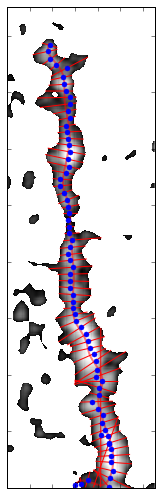

In [6]:
radfil = radfil_class.radfil(image, mask, header = header, distance = 414.)
radfil.make_fil_spine(beamwidth = 6)
radfil.build_profile(cutdist=0.1, samp_int=6, bins=40, shift=True, wrap=False)

____
## LinearStatistics

1. Whether to cut: Maybe.  We may have to, since there is the fractal problem for using pixels.

2. The default of samp_int: 3, which almost always proudce a minimum size >= 10.

3. Intermediate products: a list of masks, a list of (sets of) numbers, a list of distances along the spline.

4. Functions:

    a. For the current map:
        * Statistics: moments and percentiles.
    b. For another map (of the same shape):
        * Statistics: moments and percentiles.

In [7]:
sstats = ShapeStatistics(radfil)
lstats = LinearStatistics(radfil)
medians = lstats.statistics(statistic = ('percentile', 50.)).stats.copy()
stds = np.sqrt(lstats.statistics(statistic = ('moment', 2)).stats.copy())

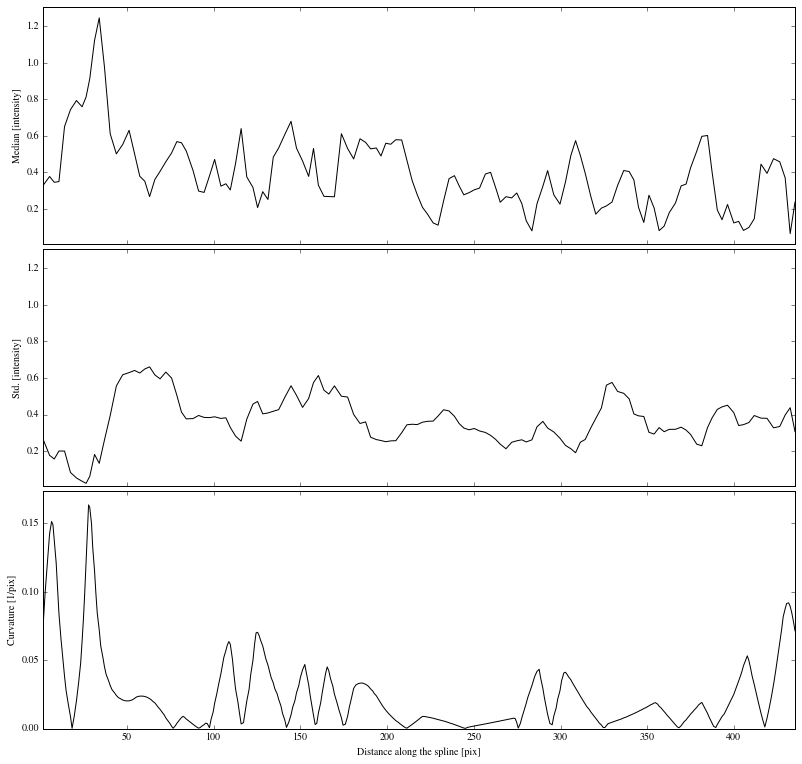

In [8]:
fig, ax = plt.subplots(figsize = (12., 12.),
                       nrows = 3)

# median
axis = ax[0]
axis.set_ylim(medians.min()-.05*(medians.max()-medians.min()),
              medians.max()+.05*(medians.max()-medians.min()))
axis.set_xlim(sstats.distance.min(), sstats.distance.max())
axis.plot(lstats.distance, medians, 'k-')
##
#axis.set_yticks(np.arange(45.*(axis.get_ylim()[0]//45.+1), axis.get_ylim()[1], 45.))
axis.set_xticklabels([])
axis.set_ylabel('Median [intensity]')

# PA rate
axis = ax[1]
axis.set_ylim(medians.min()-.05*(medians.max()-medians.min()),
              medians.max()+.05*(medians.max()-medians.min()))
axis.set_xlim(sstats.distance.min(), sstats.distance.max())
axis.plot(lstats.distance, stds, 'k-')
##
#axis.set_yticks(np.arange(45.*(axis.get_ylim()[0]//45.+1), axis.get_ylim()[1], 45.))
axis.set_xticklabels([])
axis.set_ylabel('Std. [intensity]')

# Menger curvature
axis = ax[2]
axis.set_ylim(0., sstats.mcurvature.max()+.01)
axis.set_xlim(sstats.distance.min(), sstats.distance.max())
axis.plot(sstats.distance, sstats.mcurvature, 'k-')
##
axis.set_yticks(np.arange(.05*(axis.get_ylim()[0]//.05), axis.get_ylim()[1], .05))
axis.set_xlabel('Distance along the spline [pix]')
axis.set_ylabel('Curvature [1/pix]')